# Recipe site traffic prediction

#### Main goal : 
    We want to predict which recipes will be popular 80% of the time and minimize the chance of showing unpopular recipes.

#### Context : 
    The person responsible for the blog has the following method for choosing a recipe :

    > At the moment, I choose my favorite recipe from a selection and display that on the home page. > We have noticed that traffic to the rest of the website goes up by as much as 40% if I pick a popular recipe. But I don’t > know how to decide if a recipe will be popular. More traffic means more subscriptions so this is really important to the company.
    
## Question asked :
    Can your team:
        - Predict which recipes will lead to high traffic?
        - Correctly predict high traffic recipes 80% of the time?



## Packages and data imports


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)

In [43]:
data=pd.read_csv('recipe_site_traffic_2212.csv')
data.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


## Data validation
Describe validation and cleaning steps for every column in the data.



In [44]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB
None


### First overview of the missing data

We use the missingno package to first visualise the distribution of the missing data accross the whole dataset. We will not proceed to any imputation yet as we do not want data leakage for the latter model development phase.

All modifcations will therefore be made after having separated our data set into training and testing sets.

947

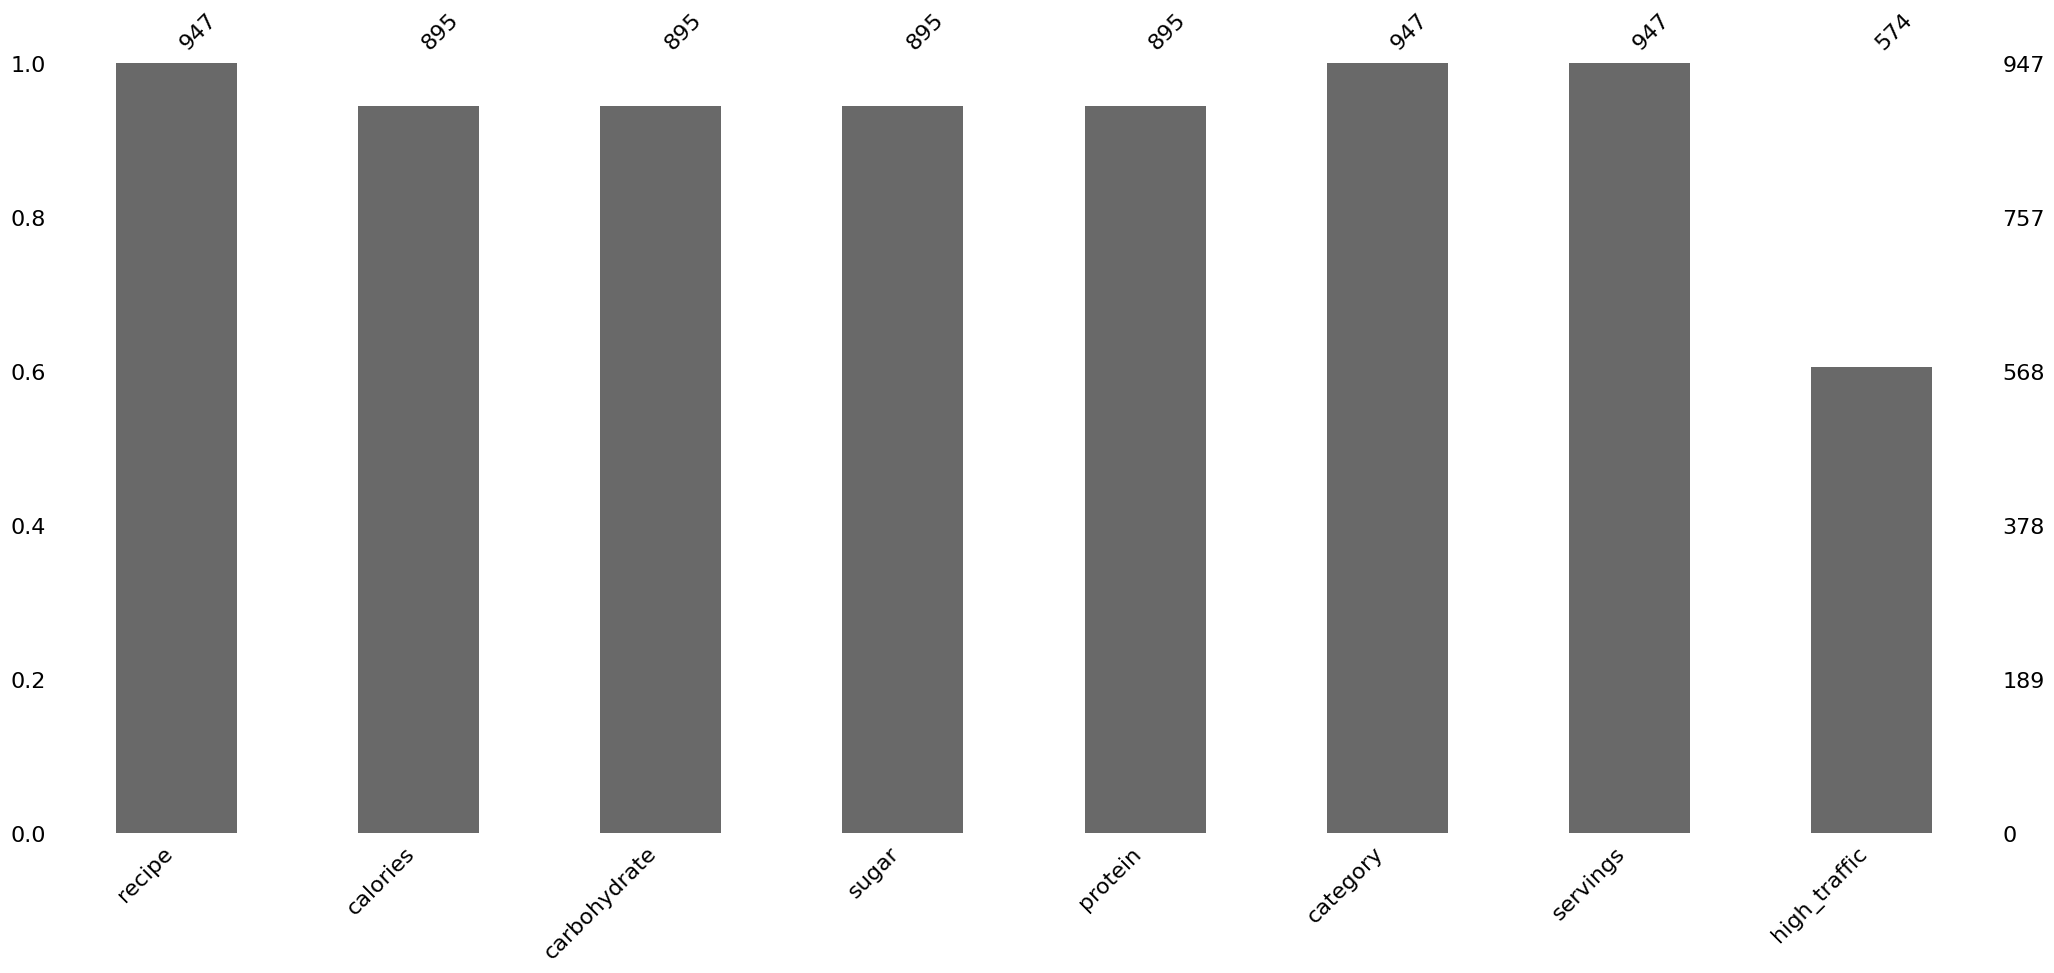

In [45]:
msno.bar(data)

len(data)

In [46]:
proportion_missing_data_carbs=data['carbohydrate'].isna().sum()/len(data)
print('The proportion of missing data in the carbs section is '+ str((proportion_missing_data_carbs*100).round(2)))

proportion_missing_data_traffic=data['high_traffic'].isna().sum()/len(data)
print('The proportion of missing data in the traffic column is ' + str((proportion_missing_data_traffic*100).round(2)))


The proportion of missing data in the carbs section is 5.49
The proportion of missing data in the traffic column is 39.39


<Axes: >

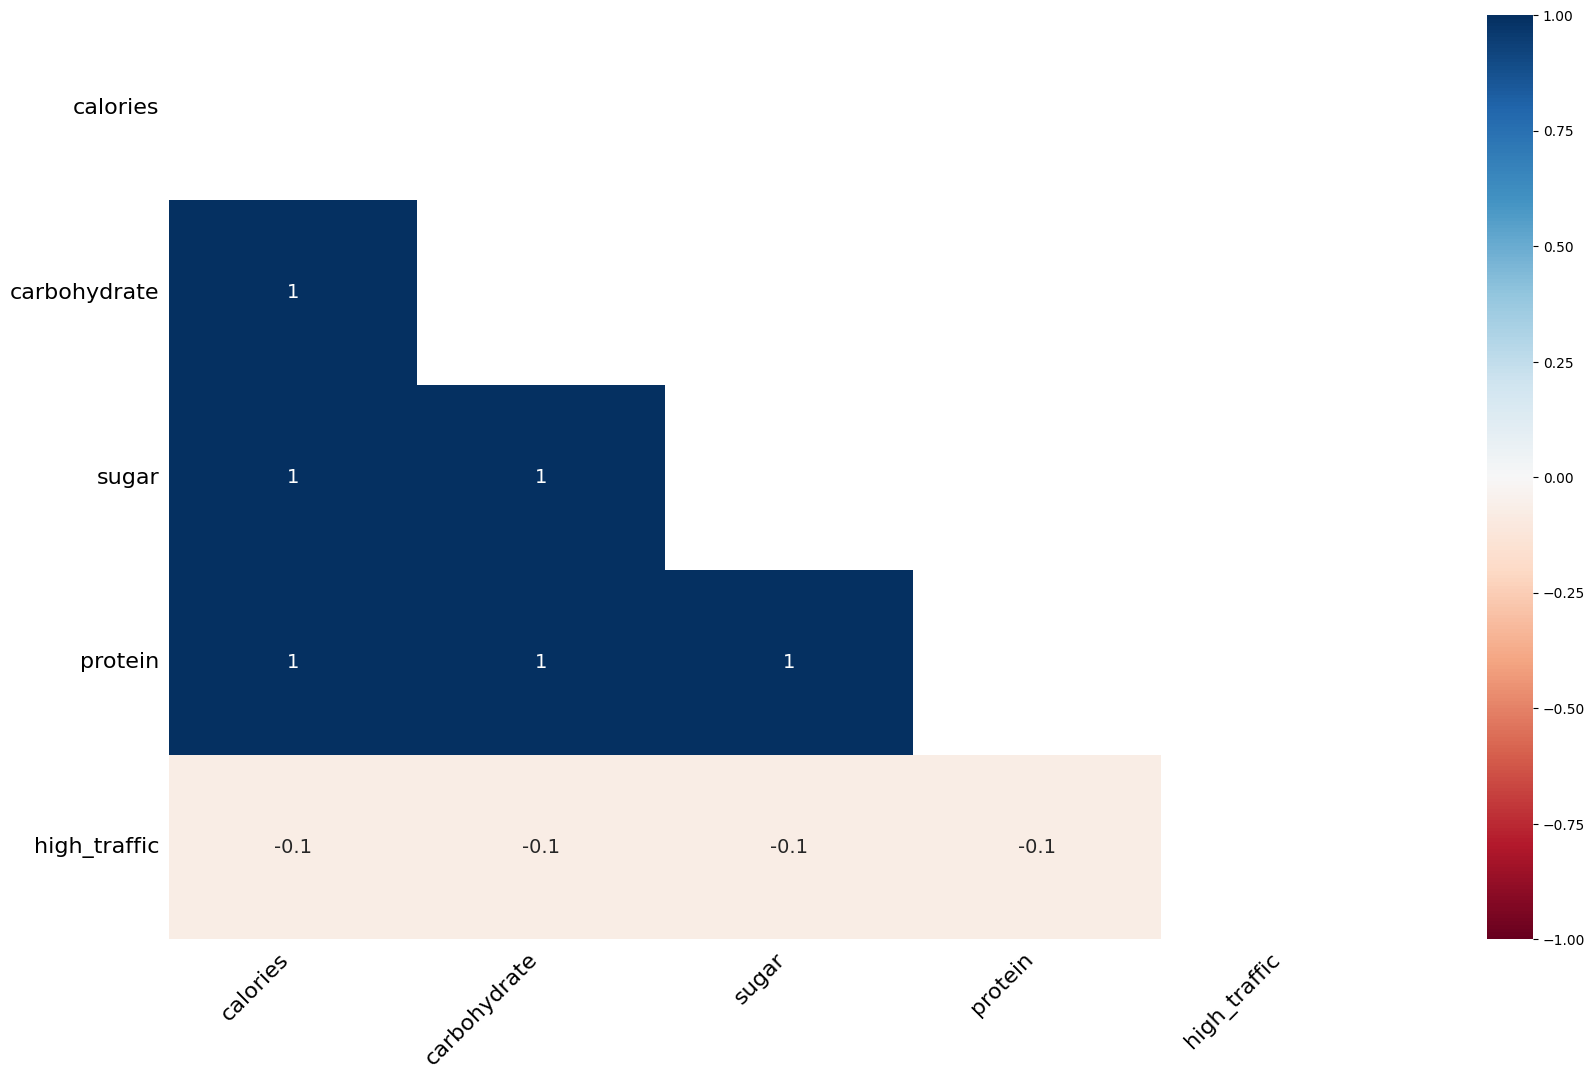

In [47]:
msno.heatmap(data)

- The "recipes", "category" and "servings" column have no missing data.
- The "calories","carbohydrate", "sugar" and "protein" have 895 values out of 947. The missing values represent less than 6 % of the observations, as their missing patterns are correlated.
- The "high_traffic" column has almost 40 % data missing. We need to further explore this to assess the quality of this data set and define strategies for data preprocessing.


### Formatting and content of the columns

In [48]:
assert len(data)==len(data.recipe.unique())

All recipe numbers are unique, therefore it does not appears as if we have duplicates.


In [49]:
print(data.category.unique())
print(data.servings.unique())
print(data.high_traffic.unique())
data[data.servings.str.len()>1]

['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']
['6' '4' '1' '2' '4 as a snack' '6 as a snack']
['High' nan]


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
451,452,1542.53,14.73,5.71,29.92,Lunch/Snacks,4 as a snack,High
548,549,1440.69,30.59,5.78,30.63,Lunch/Snacks,6 as a snack,High
735,736,513.75,65.87,18.63,18.39,Lunch/Snacks,4 as a snack,NaN


- The "category" and "servings" columns will be changed to categorical type.
- In the "category" column, we will change the value "Chicken Breast" to simply "Chicken" to have a consistent naming of the categories. No other changes are needed in this column.
- In the "servings" column, we have some observations that do not have a consistent formatting : they are written as "n as a snack" and are in the "Lunch/Snacks" category. We will therefore change it to simply "n" in the servings column.
- We have missing values for 'high_traffic'. In this column, the value is 'High' if it corresponds to a high traffic recipe and NaN if not. We will replace 'High' by 1 and the missing values by 0.


In [50]:
# In 'high_traffic': Replace 'High' by 1 and Nan by 0. 

data['high_traffic'] = np.where(data['high_traffic'] == 'High',1,0)

# Drop 'recipe'
data.drop(['recipe'], axis = 1, inplace = True)

# In 'category': Replace 'Chicken Breast' by 'Chicken'. Change type to category
data.loc[data['category']== 'Chicken Breast', 'category'] = 'Chicken'
data['category'] = data['category'].astype('category')

# Modify the unexpected values in 'servings'. Change type to category
data['servings'] = data['servings'].str[0].astype('category')

Finally, as the number of observations with missing values is relatively low (~ 6%) we will drop them.

In [51]:
data_clean=data.dropna(axis=0)


## Exploratory analysis of the data

In [52]:
data_clean['high_traffic'].value_counts(normalize = True).round(2)*100


high_traffic
1    60.0
0    40.0
Name: proportion, dtype: float64

Let us look at the distribution of high and low traffic recipes. We approximately have 60% of high traffic recipe. This will be used as a baseline to evaluate our models.

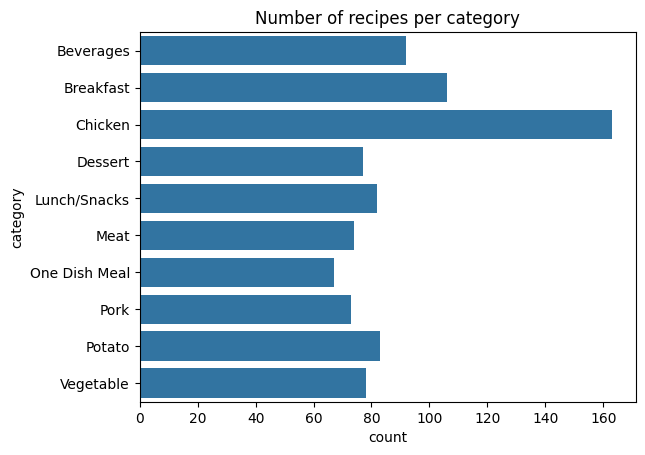

In [53]:
sns.countplot(data = data_clean, y = 'category')
plt.title('Number of recipes per category')
plt.show()

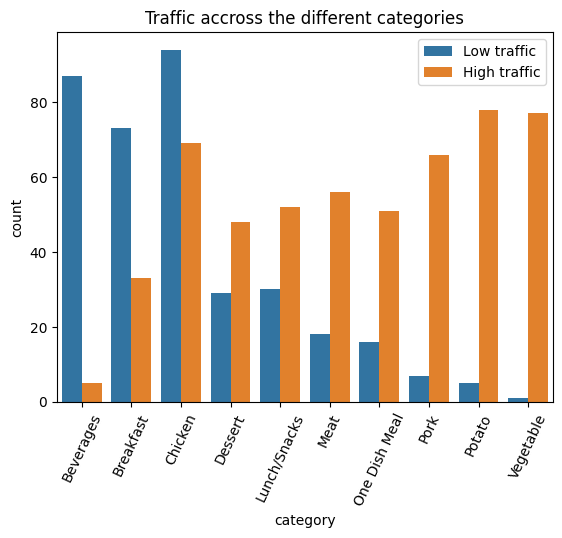

In [54]:
sns.countplot(data = data_clean, x = 'category', hue = 'high_traffic')
plt.xticks(rotation = 65)
plt.title('Traffic accross the different categories')
plt.legend(['Low traffic','High traffic'])
plt.show()

The above plot compares the number of high/low traffic recipes accross the different recipe categories. We see immediately some differences :
- Beverages and Breakfast recipes lead more often to low traffic.
- Pork, Potate and Vagetable recipes lead more often to high traffic.

Our dataset contains information about nutriments (carbohydrates, sugar, calories, protein) in our recipes. For all nutriments, the number of servings does not seem to correlate with the quantity of nutriments. This confirms what was only specified in the example: we have the nutritional values per serving.

On the following figure, we can observe the presence of outliers for the nutriments. In particular, we have high values but no low values.

Text(0.5, 0, 'Servings')

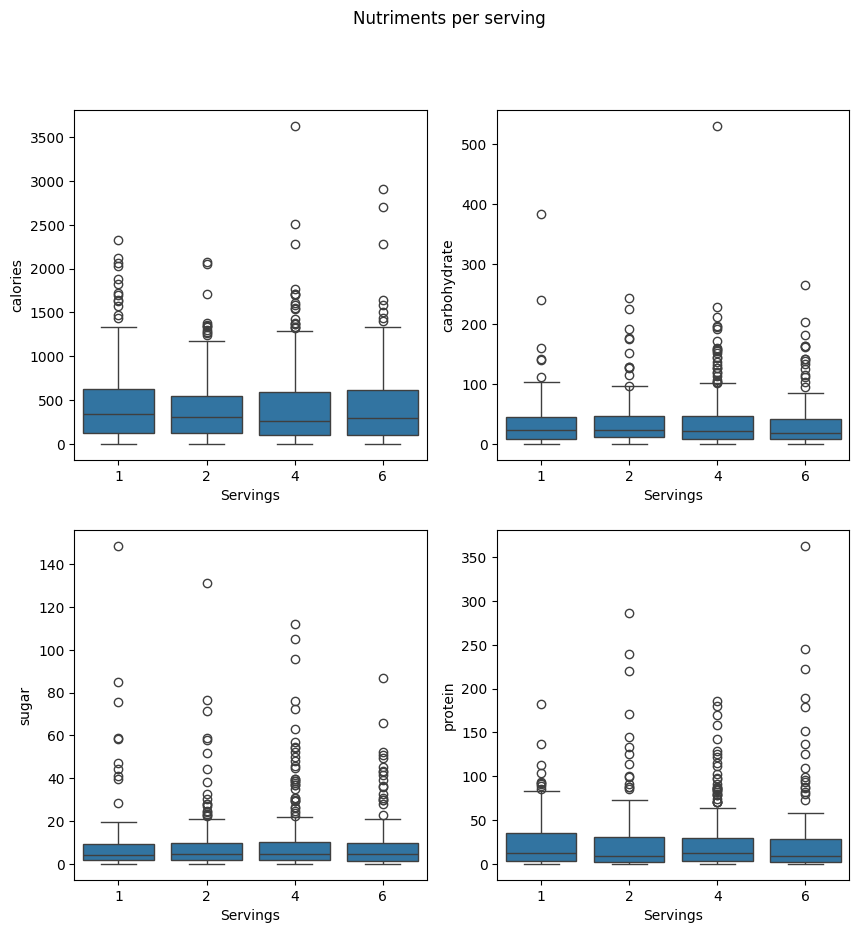

In [55]:
fig, axs = plt.subplots(2,2, figsize = [10,10])
fig.suptitle('Nutriments per serving')

sns.boxplot(data = data_clean, x= 'servings', order = ['1','2','4','6'], y = 'calories',ax = axs[0,0])
axs[0,0].set_xlabel('Servings')

sns.boxplot(data = data_clean, x= 'servings', order = ['1','2','4','6'], y = 'sugar',ax = axs[1,0])
axs[1,0].set_xlabel('Servings')

sns.boxplot(data = data_clean, x= 'servings', order = ['1','2','4','6'], y = 'carbohydrate',ax = axs[0,1])
axs[0,1].set_xlabel('Servings')

sns.boxplot(data = data_clean, x= 'servings', order = ['1','2','4','6'], y = 'protein',ax = axs[1,1])
axs[1,1].set_xlabel('Servings')



Moreover, there does not seem to be a significative correlation between nutriments and recipe popularity as can be seen below.

C:\Users\Laura\AppData\Local\Temp\ipykernel_21508\1746388417.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,0].set_xticklabels(['Low', 'High'])
C:\Users\Laura\AppData\Local\Temp\ipykernel_21508\1746388417.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,0].set_xticklabels(['Low', 'High'])
C:\Users\Laura\AppData\Local\Temp\ipykernel_21508\1746388417.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,1].set_xticklabels(['Low', 'High'])
C:\Users\Laura\AppData\Local\Temp\ipykernel_21508\1746388417.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,1].set_xticklabels(['Low', 'High'])


[Text(0, 0, 'Low'), Text(1, 0, 'High')]

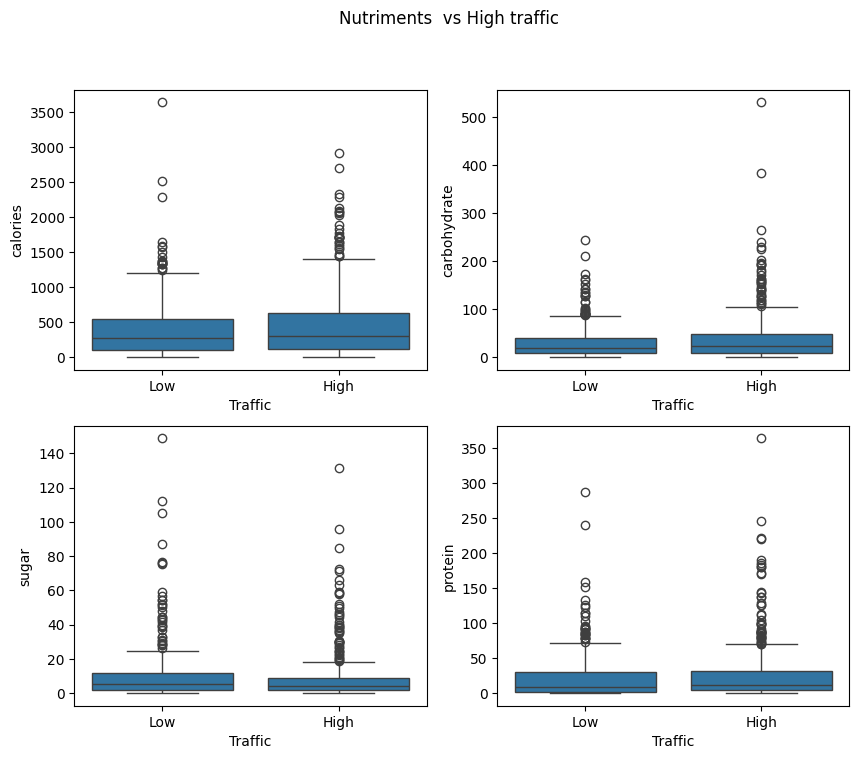

In [56]:

fig, axs = plt.subplots(2,2, figsize = [10,8])
fig.suptitle('Nutriments  vs High traffic')

sns.boxplot(data = data_clean, x= 'high_traffic', y = 'calories',ax = axs[0,0])
axs[0,0].set_xlabel('Traffic')
axs[0,0].set_xticklabels(['Low', 'High'])

sns.boxplot(data = data_clean, x= 'high_traffic', y = 'sugar',ax = axs[1,0])
axs[1,0].set_xlabel('Traffic')
axs[1,0].set_xticklabels(['Low', 'High'])

sns.boxplot(data = data_clean, x= 'high_traffic', y = 'carbohydrate',ax = axs[0,1])
axs[0,1].set_xlabel('Traffic')
axs[0,1].set_xticklabels(['Low', 'High'])

sns.boxplot(data = data_clean, x= 'high_traffic', y = 'protein',ax = axs[1,1])
axs[1,1].set_xlabel('Traffic')
axs[1,1].set_xticklabels(['Low', 'High'])



We will also compare the paired distributions of nutriments accross high and low traffic recipes. 

- Overall, there does not seem to be significant changes in the distribution of nutriments in high and low traffic recipes. 
- On the diagonal of the plot, we can see that the nutriments have skewed distributions.

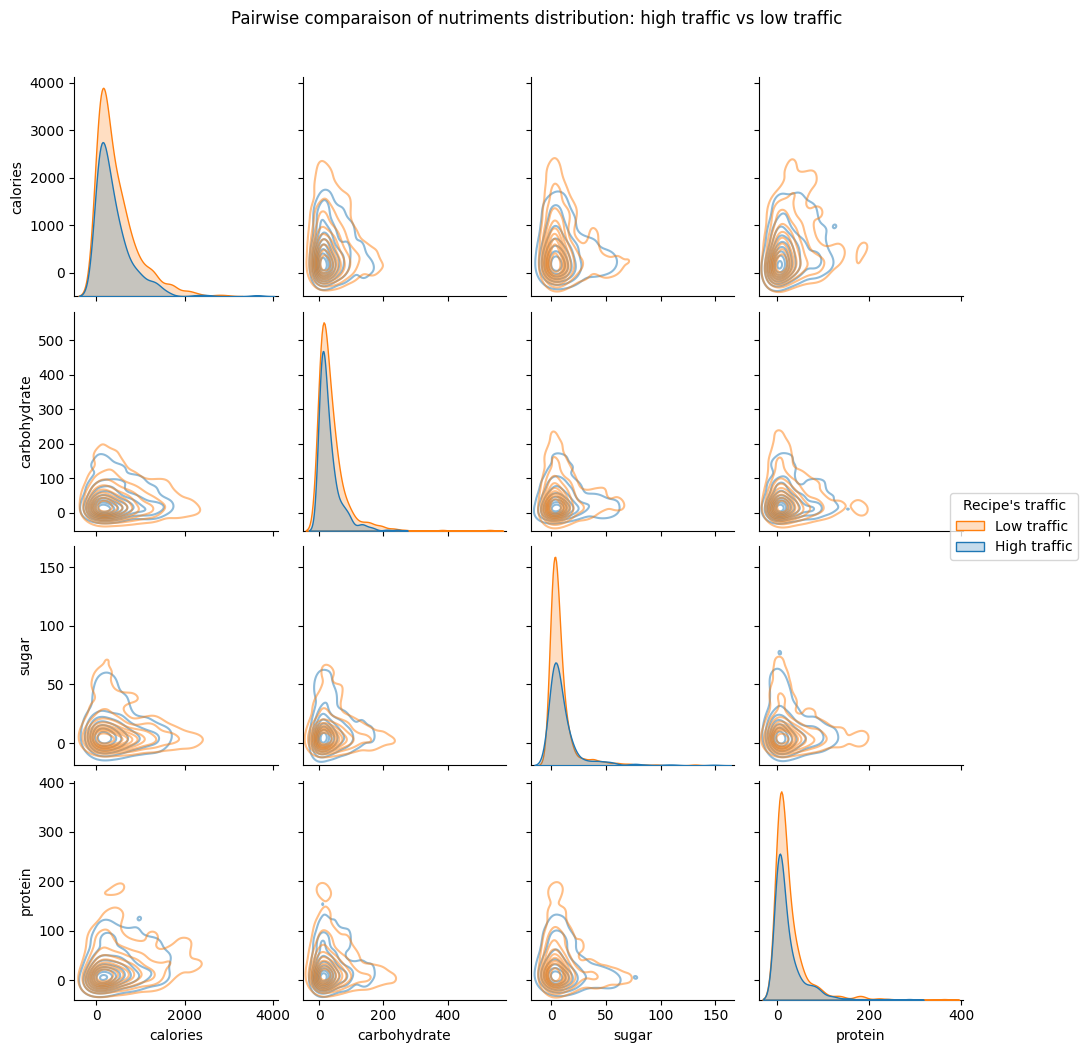

In [57]:
g=sns.pairplot(data = data_clean, hue = 'high_traffic', kind = 'kde',plot_kws={'alpha':0.5})
plt.suptitle('Pairwise comparaison of nutriments distribution: high traffic vs low traffic', y = 1.05)
g._legend.remove()
g.fig.legend(labels=['Low traffic', 'High traffic'], title="Recipe's traffic", loc='center right')


## Model development for predicting high traffic recipes

We will first separate our data in training and testing sets. We will take 80% of the dataset data_clean for training and the remaining 20% for testing. We will also specify the random state to ensure reproducibility.

In [58]:
X=data_clean.drop('high_traffic', axis=1)
y=data_clean['high_traffic']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

As we have categorical variables for 'servings' and 'category', we will do a one-hot encoding of those features.


In [59]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)


The problem asked by the Product Manager is a supervised learning classification problem. The requested task is to maximise the precision of the model, and if possible attain a precision score of 80%. 



### Baseline model

We would like to define a model as a baseline to be able to better assess the performances of later models we will develop.


In the original given dataset we had around 60% of high traffic recipes. Moreover, the current decision process (described in the email) can be mimicked using a DummyClassifier, that is a deterministic model that predicts high traffic always. This will replicate the current precision of 60%.


In [60]:
dummy =  DummyClassifier(random_state = 42)
dummy.fit(X_train,y_train)
y_pred_dummy = dummy.predict(X_test)
precision_dummy = precision_score(y_test,y_pred_dummy).round(2)
print(f'DummyClassifier precision = {precision_dummy}')

DummyClassifier precision = 0.6


### Model development and assesment

As said before, we are working on a classification problem on which we wish to maximize precision.

We will consider, for comparison, three common classification algorithms :
- Random Forests
- Support Vector Classification
- Logistic regression 

We will use cross-validation to ensure the best hyperparameter tuning for each model and also to decide on scalers for the preprocessing phase of the numeric variables. The use of cross-validation will ensure we can consistently explore and find a good model for our classification model, and choose the best one among the options explored.

#### Random forests

In [61]:
pipeRFC = Pipeline([
('preprocesser', ColumnTransformer([('scaler',StandardScaler(),['calories', 'carbohydrate', 'sugar', 'protein'])], remainder = 'passthrough')),
('classifier', RandomForestClassifier(random_state = 42))
])

parameters = {'preprocesser__scaler': [StandardScaler(), MinMaxScaler()],
 'classifier__criterion': ['gini', 'entropy', 'log_loss'],
 'classifier__n_estimators': [10,20,50,100,200],
 'classifier__max_depth': [2,5,10,15],
 'classifier__bootstrap': [True,False],
 'classifier__n_jobs': [-1]
}
 
gridRFC = GridSearchCV(pipeRFC, parameters, cv=5, scoring = 'precision').fit(X_train, y_train)

print('Test set score for Random Forest Classifier : ' + str(gridRFC.score(X_test, y_test)))



Test set score for Random Forest Classifier : 0.7821782178217822


In [62]:
best_params = gridRFC.best_params_
print(best_params)

{'classifier__bootstrap': True, 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__n_estimators': 20, 'classifier__n_jobs': -1, 'preprocesser__scaler': StandardScaler()}


#### Support vector classifier

In [63]:
pipeSVC = Pipeline([
('preprocesser', ColumnTransformer([('scaler',StandardScaler(),['calories', 'carbohydrate', 'sugar', 'protein'])],remainder = 'passthrough')),
('classifier', SVC(random_state = 42, probability = True))
])

parameters = {'preprocesser__scaler': [StandardScaler(), MinMaxScaler()],
 'classifier__C': [0.01,0.1,1,2,10],
 'classifier__gamma': [1,0.1,0.01,0.001],
 'classifier__kernel': [ 'rbf', 'poly', 'sigmoid','linear']
}
 
gridSVC = GridSearchCV(pipeSVC, parameters, cv=5, scoring = 'precision').fit(X_train, y_train)

print('Test set score for SVC: ' + str(gridSVC.score(X_test, y_test)))



Test set score for SVC: 0.8255813953488372


In [64]:
best_params = gridSVC.best_params_
print(best_params)

{'classifier__C': 2, 'classifier__gamma': 1, 'classifier__kernel': 'rbf', 'preprocesser__scaler': MinMaxScaler()}


#### Logistic regression


In [65]:
pipeLR = Pipeline([
('preprocesser', ColumnTransformer([('scaler',StandardScaler(),['calories', 'carbohydrate', 'sugar', 'protein'])],remainder = 'passthrough')),
('classifier', LogisticRegression(random_state = 42))
])

parameters = {'preprocesser__scaler': [StandardScaler(), MinMaxScaler()],
 'classifier__penalty': ['l1','l2'],
 'classifier__C': [0.1, 1,2,10],
 'classifier__solver': ['liblinear']
}
 
gridLR = GridSearchCV(pipeLR, parameters, cv=5, scoring = 'precision').fit(X_train, y_train)

print('Test set score: ' + str(gridLR.score(X_test, y_test)))

Test set score: 0.8541666666666666


In [66]:
best_params = gridLR.best_params_
print(best_params)

{'classifier__C': 2, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'preprocesser__scaler': MinMaxScaler()}


#### Model evaluation and selection

The scores obtained by the best parameters for each model are :
- Random forest precision : 78.2 %
- SVC precision : 82.6 %
- Logistic regression precision : 85.4 %

The three evaluated models performed better than the baseline model. However, only SVC and Logistic regression attained the desired precision.

Here are more details about the performances of the models.

In [67]:
y_pred_LR = gridLR.predict(X_test)
y_pred_SVC = gridSVC.predict(X_test)
y_pred_RFC = gridRFC.predict(X_test)

dict_score = {'precision': [precision_score(y_test, y_pred_RFC), precision_score(y_test, y_pred_SVC), precision_score(y_test, y_pred_LR)],
                'accuracy': [accuracy_score(y_test, y_pred_RFC), accuracy_score(y_test, y_pred_SVC), accuracy_score(y_test, y_pred_LR)],
                 'recall': [recall_score(y_test, y_pred_RFC), recall_score(y_test, y_pred_SVC), recall_score(y_test, y_pred_LR)],
                   'F1 Score': [f1_score(y_test, y_pred_RFC), f1_score(y_test, y_pred_SVC), f1_score(y_test, y_pred_LR)]  }

(pd.DataFrame(dict_score, index = ['RFC', 'SVC', 'LogReg'])*100).round(1)

,precision,accuracy,recall,F1 Score
RFC,78.2,72.1,73.8,76.0
SVC,82.6,71.5,66.4,73.6
LogReg,85.4,78.2,76.6,80.8


The logistic regression model is the best one overall, almost always achieving the highest score. This is also confirmed by the ROC curve.

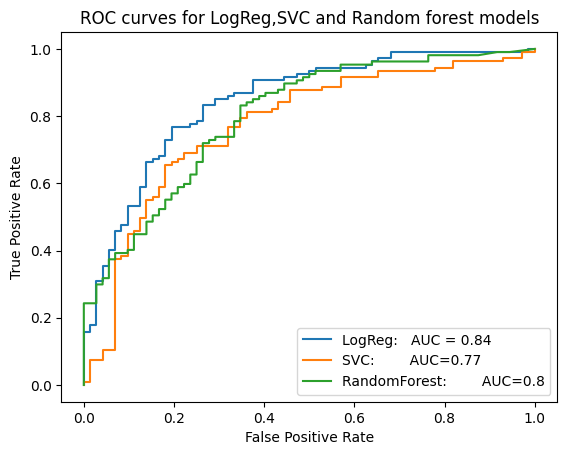

In [68]:
y_pred_probaLR = gridLR.best_estimator_.predict_proba(X_test)[:,1]
fprLR, tprLR, _ = roc_curve(y_test,  y_pred_probaLR)

y_pred_probaSVC = gridSVC.best_estimator_.predict_proba(X_test)[:,1]
fprSVC, tprSVC, _ = roc_curve(y_test,  y_pred_probaSVC)

y_pred_probaRF=gridRFC.best_estimator_.predict_proba(X_test)[:,1]
fprRF, tprRF, _=roc_curve(y_test, y_pred_probaRF)

aucLR = roc_auc_score(y_test, y_pred_probaLR).round(2)
aucSVC = roc_auc_score(y_test, y_pred_probaSVC).round(2)
aucRF=roc_auc_score(y_test,y_pred_probaRF).round(2)

plt.plot(fprLR, tprLR, label = f'LogReg:   AUC = {aucLR}')
plt.plot(fprSVC, tprSVC, label = f'SVC:        AUC={aucSVC}')
plt.plot(fprRF, tprRF, label = f'RandomForest:        AUC={aucRF}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for LogReg,SVC and Random forest models')
plt.legend(loc = 4)

An important feature of the Logistic regression model is its interpretability. That is, the fitted and tuned model gives us the importance of each feature in the decision process. The importance of each feature can be seen on the following plot.


C:\Users\Laura\AppData\Local\Temp\ipykernel_21508\1330708263.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = coeff, y = 'feature', x = 'coeff', palette = "vlag", ax = ax)
C:\Users\Laura\AppData\Local\Temp\ipykernel_21508\1330708263.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['Beverages','Breakfast','Chicken','calories','protein', '2 servings', 'carbohydrate','sugar','Dessert','Lunch/Snacks','4 servings', 'One Dish Meal', '6 servings', 'Meat', '1 serving', 'Pork', 'Potato', 'Vegetable'])


Text(0.5, 1.0, 'Coefficients of features in the tuned LogReg model')

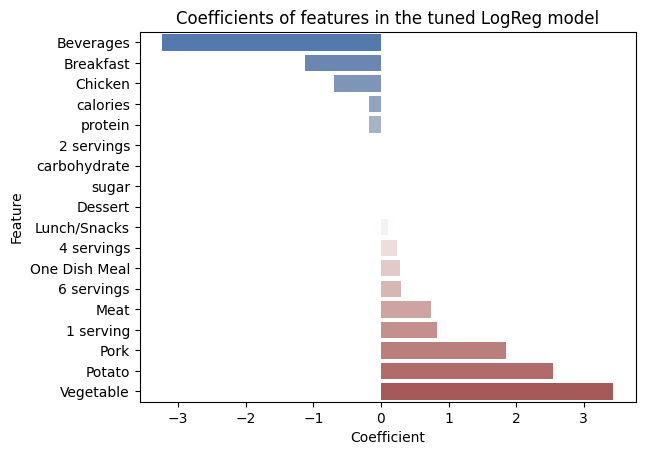

In [69]:
coeff = pd.DataFrame([X_train.columns, gridLR.best_estimator_['classifier'].coef_[0]]).transpose()
coeff.columns = ['feature', 'coeff']
coeff.sort_values('coeff', inplace = True)

fig, ax = plt.subplots()

sns.barplot(data = coeff, y = 'feature', x = 'coeff', palette = "vlag", ax = ax)
ax.set_yticklabels(['Beverages','Breakfast','Chicken','calories','protein', '2 servings', 'carbohydrate','sugar','Dessert','Lunch/Snacks','4 servings', 'One Dish Meal', '6 servings', 'Meat', '1 serving', 'Pork', 'Potato', 'Vegetable'])
ax.set_ylabel('Feature')
ax.set_xlabel('Coefficient')

plt.title('Coefficients of features in the tuned LogReg model')

As observed in the exploratory analysis, certain categories of recipes lead to high traffic : vegetable, potato, pork.
Other categories such as beverages, breakfast and chicken seem to correlate with low traffic.
 

Finally, the model we choose is Logistic regression with the following parameters :
- using the l1 norm for penalty,
- liblinear as the solver
- normalizing using a MinMaxScaler.

## Business metric

We propose to use as a metric the proportion of recipes leading to high traffic on the website. This metric is easy to track and is a good proxy for measuring the popularity of the recipe.

Moreover, the precision given by the developed models is precisely a measure of this business metric.

### Baseline

As seen during the exploratory phase, we currently have 60% of the displayed recipes leading to high traffic. Therefore, the baseline for our business metric is 60%.
This was also achieved with our baseline model.

### Our predictions

We developed three models. In all cases, the predictions suggest we can improve the current proportion of popular recipes on the website.
In particular, the logistic regression model surpassed our goals and attained a score of roughly 85%, the highest among the tested models.

Moreover, this model gives us also criterions to be able to asses the popularity of recipes. That is, the model is interpretable.


## Final summary



We were tasked to predict which recipes will lead to high traffic. To do so, after data validation and exploration, we developed 3 models and chose the most performing one.

The current decision process to select recipes to put online has a precision of 60%, while the proposed model, using Logistic Regression, leads to a precision of 85%. 

Consequently, using the tuned LogReg model to classify recipes should be used to maximise traffic on the website instead of the currently used method.

Moreover, we were able to identify features leading to high traffic recipes:

- Vegetables
- Potato
- Pork

We also identified features leading to low traffic recipes:

- Beverage
- Breakfast
- Chicken
- Calories

The product team should be attentive to these categories of recipes in case they decide not to use the Logistic regression model.

